In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
train = pd.read_csv('data/emnist-balanced-train.csv', header=None)
test = pd.read_csv('data/emnist-balanced-test.csv', header=None)

train.shape, test.shape

((112800, 785), (18800, 785))

In [7]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,41,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Plik z danymi zawiera 112800 danych o obrazach 28x28 pikseli (785 kolumn, 1. z nich jest etykietą obrazu). Etykiety te są numerami od 0 do 46 (47 łącznie: cyfry, duże i małe litery alfabetu angielskiego). Są one zmapowane w pliku emnist-balanced-mapping.txt

In [16]:
mapping = pd.read_csv('data/emnist-balanced-mapping.txt', delimiter=' ', header=None)
mapping_dict = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

print(f"Mapping size: {len(mapping)}")
print(dict(list(mapping_dict.items())))

Mapping size: 47
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


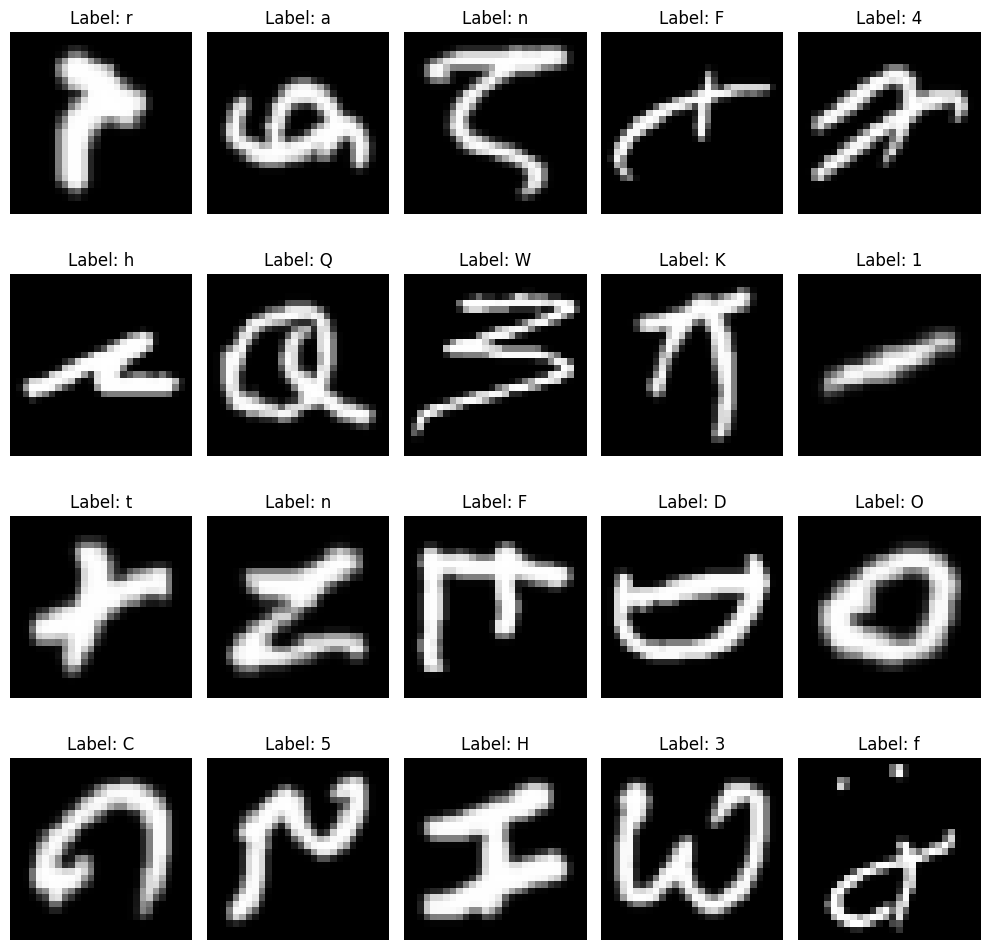

In [19]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    example = train.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Są odwrócone domyślnie, więc przekręcam je do pionu

In [20]:
for i in range(train.shape[0]):
    pixels = train.iloc[i,1:]
    
    image = pixels.values.reshape(28,28, 1).T
    pixels = image.flatten()
    
    train.iloc[i,1:] = pixels

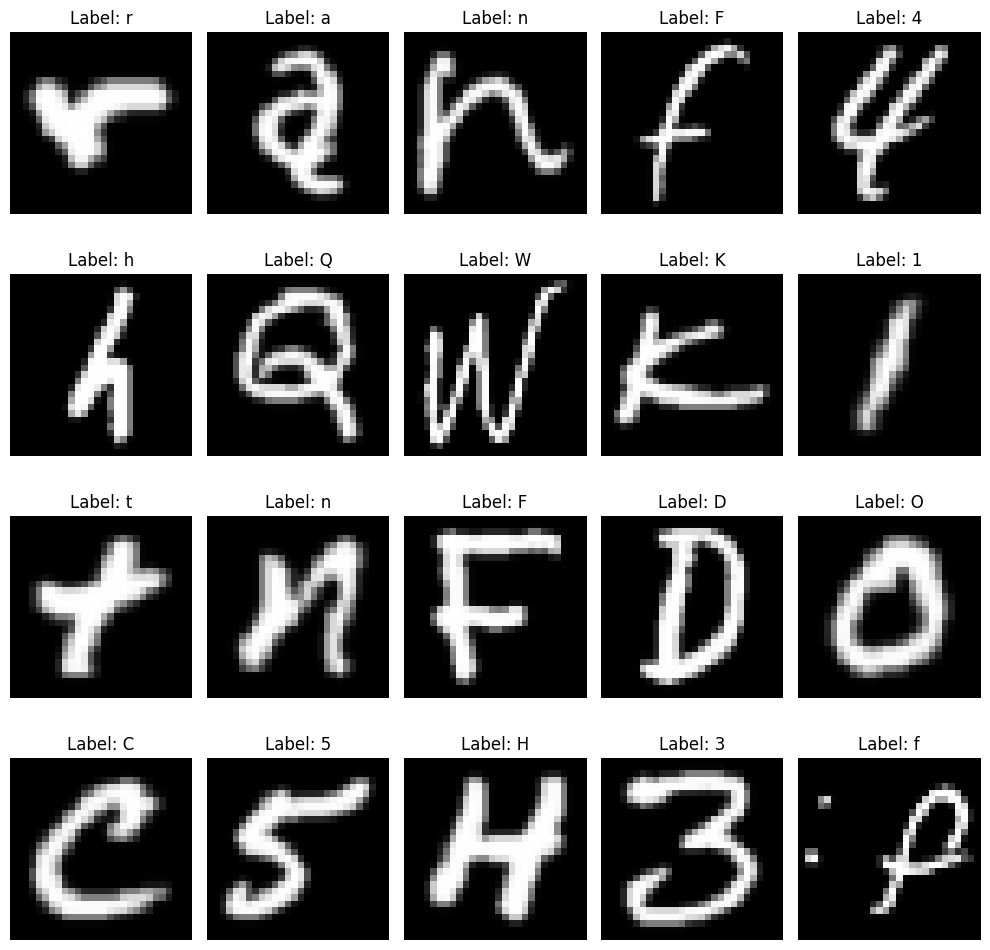

In [21]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    example = train.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
print(train.iloc[:, 1:].max().max()) # kolor

255


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
from models import CNNBlock, SimpleCNN
from models import ResidualBlock, ResNet

In [38]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split

class EMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype('float32')
        self.y = y.astype('int64')
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].reshape(28, 28)
        X = self.transform(X)
        y = self.y[idx]
        return X, y

In [45]:
train_X = train.iloc[:, 1:].reset_index(drop=True).values / 255.0
train_y = train.iloc[:, 0].reset_index(drop=True).values

train_dataset = EMNISTDataset(train_X, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)


In [46]:
test_X = test.iloc[:, 1:].reset_index(drop=True).values / 255.0
test_y = test.iloc[:, 0].reset_index(drop=True).values

test_dataset = EMNISTDataset(test_X, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)


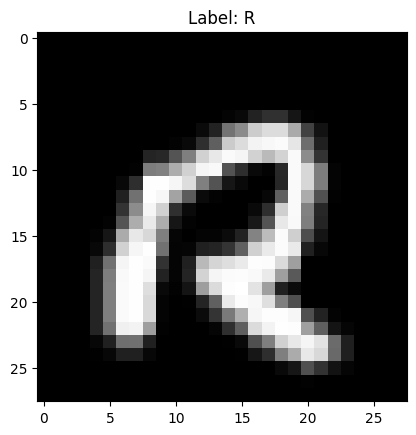

In [47]:
sampleX, sampley = next(iter(train_dataloader))

sampleX.shape, sampley.shape

image = sampleX[0].squeeze() #.permute(-2, -1)

plt.imshow(image, cmap='gray')
plt.title(f'Label: {mapping_dict[sampley[0].item()]}')
plt.show()

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

model_cnn = SimpleCNN().to(device)

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_cnn = ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.1, patience=5)
scaler_cnn = GradScaler()

c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [53]:
model_rn = ResNet(ResidualBlock, layers=[1, 1, 1, 1], num_classes=47)
criterion_rn = nn.CrossEntropyLoss()
optimizer_rn = optim.Adam(model_rn.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_rn = ReduceLROnPlateau(optimizer_rn, mode='min', factor=0.1, patience=5)
scaler_rn = GradScaler()

In [55]:
EPOCHS = 10

Trenowanie splotowej sieci neuronowej (CNN):

In [56]:
for epoch in range(EPOCHS):
    # Training Phase
    model_cnn.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    
    for inputs, labels in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast("cuda"):
            outputs = model_cnn(inputs)
            loss = criterion_cnn(outputs, labels)
        
        optimizer_cnn.zero_grad()
        scaler_cnn.scale(loss).backward()
        scaler_cnn.step(optimizer_cnn)
        scaler_cnn.update()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        
        train_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)
    
    train_epoch_loss = train_loss / len(train_dataloader)
    train_epoch_accuracy = 100 * train_correct / train_total

    # Validation Phase
    model_cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_progress_bar = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
    
    with torch.no_grad():
        for inputs, labels in val_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast("cuda"):
                outputs = model_cnn(inputs)
                loss = criterion_cnn(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            val_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)
    
    val_epoch_loss = val_loss / len(test_dataloader)
    val_epoch_accuracy = 100 * val_correct / val_total

    # Print Epoch Summary
    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")
    
    # Step the scheduler with validation loss
    scheduler_cnn.step(val_epoch_loss)

print("Finished Training")


Epoch 1/10 [Train]:   0%|          | 0/111 [00:00<?, ?it/s]

c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

Testowanie wyników trenowania CNN:

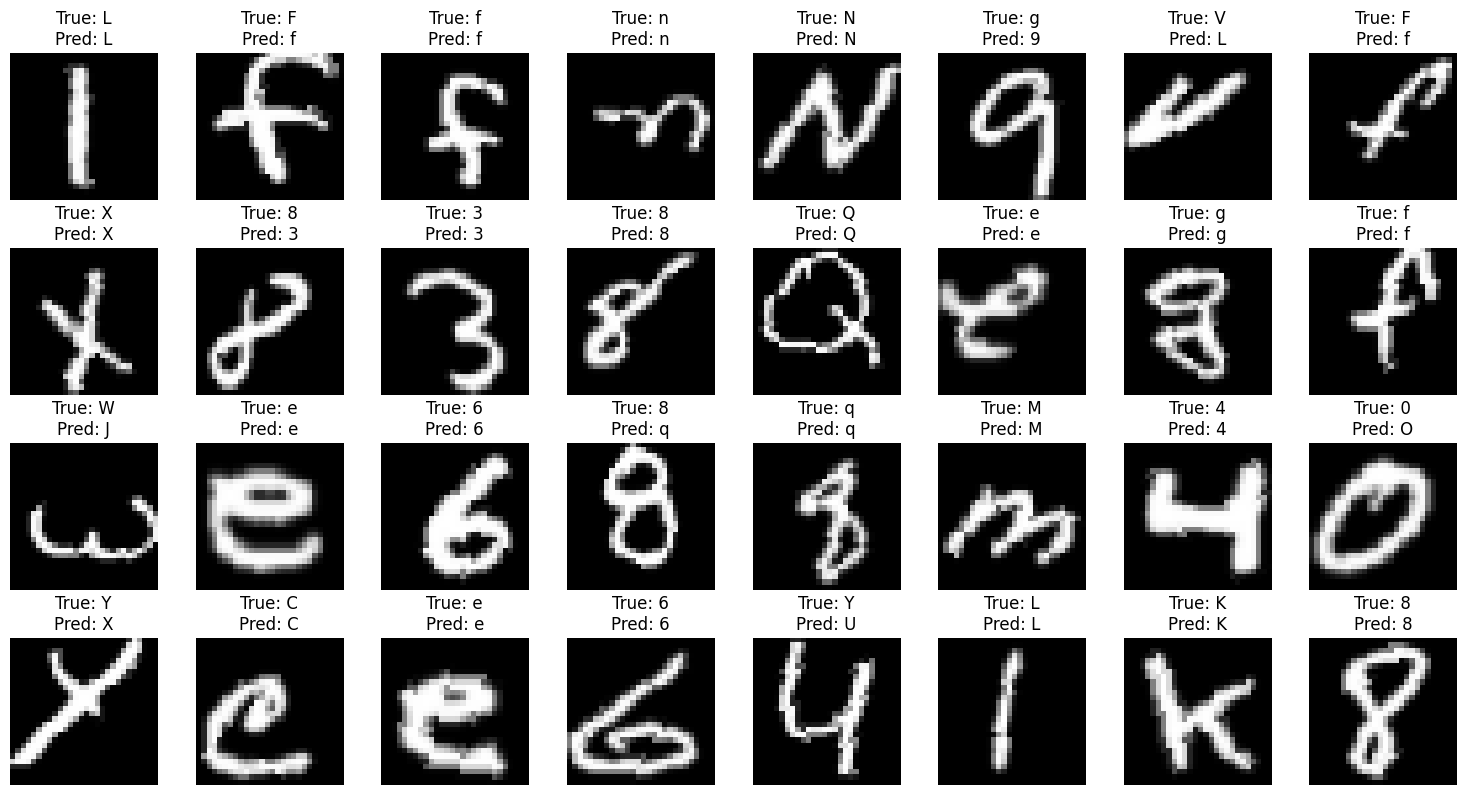

In [16]:
# Set the model to evaluation mode
model_cnn.eval()

# Get a batch of data from the dataloader
inputs, labels = next(iter(test_dataloader))

# Move the inputs and labels to the device
inputs, labels = inputs.to(device), labels.to(device)

# Perform the forward pass to get predictions
outputs = model_cnn(inputs)

# Get the predicted class
_, preds = torch.max(outputs, 1)

# Plot the images along with the true and predicted labels
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    img = inputs[i].cpu().numpy().squeeze()
    true_label = mapping_dict[labels[i].item()]
    pred_label = mapping_dict[preds[i].item()]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {true_label}\nPred: {pred_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Trenowanie Resztkowej Sieci Neuronowej (RNN):


In [57]:
for epoch in range(EPOCHS):
    # Training Phase
    model_rn.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    
    for inputs, labels in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast("cuda"):
            outputs = model_rn(inputs)
            loss = criterion_rn(outputs, labels)
        
        optimizer_rn.zero_grad()
        scaler_rn.scale(loss).backward()
        scaler_rn.step(optimizer_rn)
        scaler_rn.update()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        
        train_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)
    
    train_epoch_loss = train_loss / len(train_dataloader)
    train_epoch_accuracy = 100 * train_correct / train_total

    # Validation Phase
    model_rn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_progress_bar = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
    
    with torch.no_grad():
        for inputs, labels in val_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast("cuda"):
                outputs = model_rn(inputs)
                loss = criterion_rn(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            val_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)
    
    val_epoch_loss = val_loss / len(test_dataloader)
    val_epoch_accuracy = 100 * val_correct / val_total

    # Print Epoch Summary
    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")
    
    # Step the scheduler with validation loss
    scheduler_rn.step(val_epoch_loss)

print("Finished Training")


Epoch 1/10 [Train]:   0%|          | 0/111 [00:00<?, ?it/s]c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

Testowanie RNN:

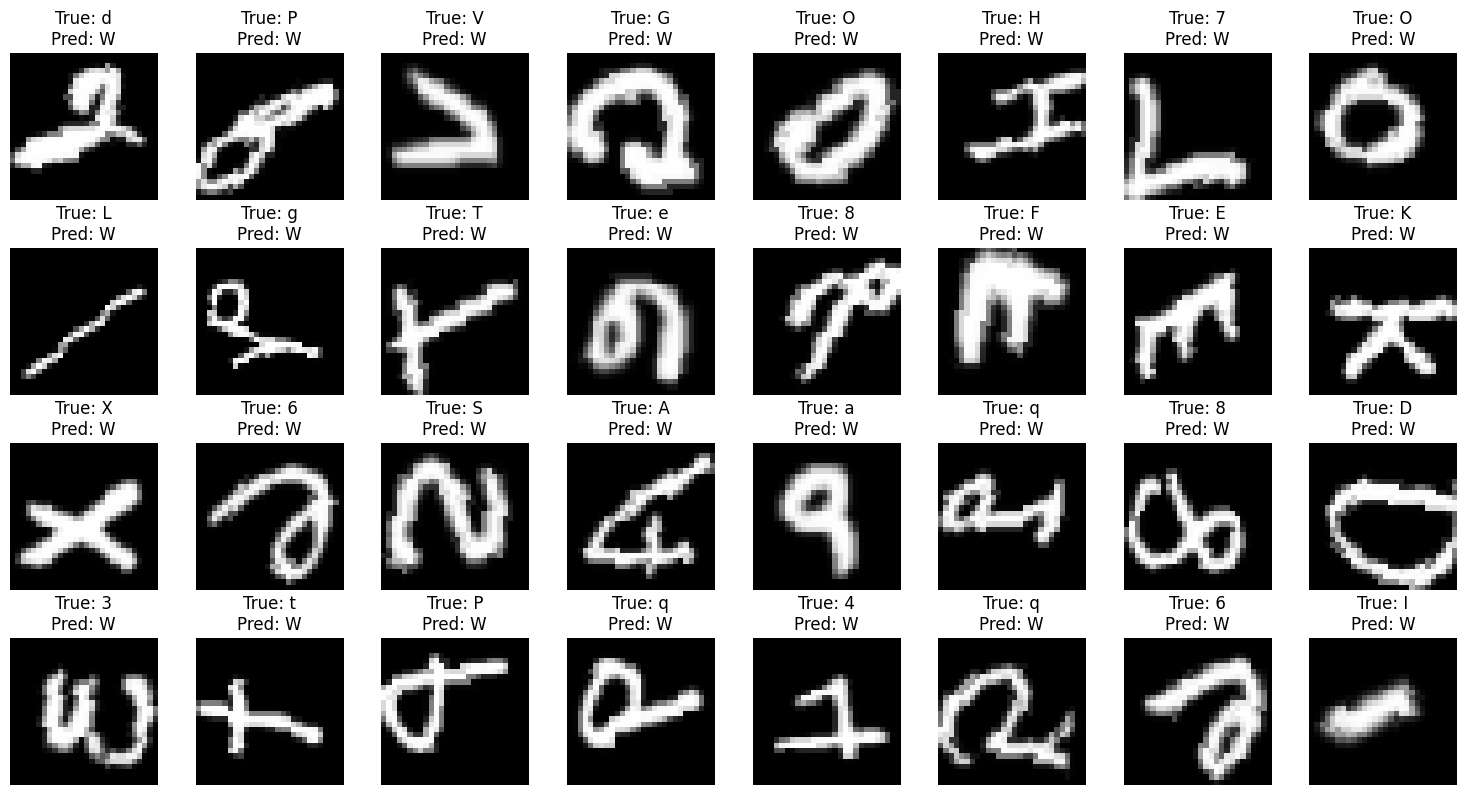

In [58]:
# Set the model to evaluation mode
model_rn.eval()

# Get a batch of data from the dataloader
inputs, labels = next(iter(test_dataloader))

# Move the inputs and labels to the device
inputs, labels = inputs.to(device), labels.to(device)

# Perform the forward pass to get predictions
outputs = model_rn(inputs)

# Get the predicted class
_, preds = torch.max(outputs, 1)

# Plot the images along with the true and predicted labels
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    img = inputs[i].cpu().numpy().squeeze()
    true_label = mapping_dict[labels[i].item()]
    pred_label = mapping_dict[preds[i].item()]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {true_label}\nPred: {pred_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
torch.save(model_cnn.state_dict(), 'model_cnn.pth')
torch.save(model_rn.state_dict(), 'model_rn.pth')